## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgbm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from imblearn.over_sampling import ADASYN
%matplotlib inline

## Collate All Preprocessing Steps

In [2]:
df = pd.read_csv("./data/cs-training.csv")
df = df.drop("Unnamed: 0", axis=1)
df = df.loc[df["DebtRatio"] <= df["DebtRatio"].quantile(0.86)]
df = df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df["RevolvingUtilizationOfUnsecuredLines"] < 13)]
df = df.loc[df["NumberOfTimes90DaysLate"] <= 17]
df["MonthlyIncome"] = df["MonthlyIncome"].fillna(df["MonthlyIncome"].median())
df["NumberOfDependents"] = df["NumberOfDependents"].fillna(df["NumberOfDependents"].mode()[0])
income_median = df["MonthlyIncome"].median()
dependents_mode = df["NumberOfDependents"].mode()[0]
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
df.to_csv("./data/preprocess.csv", index=False)

In [4]:
test = pd.read_csv("./data/cs-test.csv")
test.isnull().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

In [5]:
test["MonthlyIncome"] = test["MonthlyIncome"].fillna(test["MonthlyIncome"].median())
test["NumberOfDependents"] = test["NumberOfDependents"].fillna(dependents_mode)

In [ ]:
def preprocess_(df):
    df = df.drop("Unnamed: 0", axis=1)
    df = df.loc[df["DebtRatio"] <= df["DebtRatio"].quantile(0.86)]
    df = df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df["RevolvingUtilizationOfUnsecuredLines"] < 13)]
    df = df.loc[df["NumberOfTimes90DaysLate"] <= 17]
    df["MonthlyIncome"] = df["MonthlyIncome"].fillna(income_median)
    df["NumberOfDependents"] = df["NumberOfDependents"].fillna(df["NumberOfDependents"].mode()[0])

In [6]:
X = df.drop("SeriousDlqin2yrs", axis=1)
Y = df["SeriousDlqin2yrs"]

In [ ]:
cv_results = cross_validate(XGBClassifier(), X, Y, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state = 0))

In [ ]:
cv_results

In [ ]:
cv_results = cross_validate(XGBClassifier(scale_pos_weight=(len(Y) - sum(Y)) / sum(Y)), X, Y, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state = 0))

In [ ]:
cv_results

In [ ]:
########### 0.857
# test_X = test.drop(["Unnamed: 0", "SeriousDlqin2yrs"],axis=1)
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5],
#         'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2]
#         }
# xgb = XGBClassifier(n_estimators=100, random_state=0)
# model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=40, scoring='roc_auc', n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state = 0), verbose=3, random_state=0)
# model.fit(X, Y)
# predict_prob = model.predict_proba(test_X)[:, -1]

In [ ]:
########### BEST 0.85806
# test_X = test.drop(["Unnamed: 0", "SeriousDlqin2yrs"],axis=1)
# params = {
#         'min_child_weight': list(range(1,10,2)),
#         'gamma':[i/10.0 for i in range(0,5)],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree':[i/10.0 for i in range(6,10)],
#         'max_depth':range(3,10,2),
#         'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
#         'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05, 0.2, 0.4, 0.6, 0.8, 1],
#         'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
#         'n_estimators': [100, 150, 200, 250, 300]
#         }
# xgb = XGBClassifier(random_state=0)
# model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state = 0), verbose=3, random_state=0)
# model.fit(X, Y)
# predict_prob = model.predict_proba(test_X)[:, -1]

In [ ]:
########### 0.85708
# test_X = test.drop(["Unnamed: 0", "SeriousDlqin2yrs"],axis=1)
# param_test ={'num_leaves': sp_randint(6, 50), 
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
# clf = lgbm.LGBMClassifier(max_depth=-1, random_state=0, silent=True, metric='roc_auc', n_jobs=-1, n_estimators=5000)
# model = RandomizedSearchCV(clf, param_distributions=param_test, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state = 0), verbose=3, random_state=0)
# model.fit(X, Y)
# predict_prob = model.predict_proba(test_X)[:, -1]

In [ ]:
# model.get_params()

In [7]:
# ########### BEST 0.85874
# test_X = test.drop(["Unnamed: 0", "SeriousDlqin2yrs"],axis=1)
# params = {
#         'min_child_weight': list(range(1,10,2)),
#         'gamma':[i/10.0 for i in range(0,5)],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree':[i/10.0 for i in range(6,10)],
#         'max_depth':range(3,10,2),
#         'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
#         'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05, 0.2, 0.4, 0.6, 0.8, 1],
#         'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2],
#         'n_estimators': [100, 150, 200, 250, 300,350,400,450,500]
#         }
# xgb = XGBClassifier(random_state=0)
# model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state = 0), verbose=3, random_state=0)
# model.fit(X, Y)
# predict_prob = model.predict_proba(test_X)[:, -1]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.6min finished


In [8]:
result = pd.DataFrame({"Id": test["Unnamed: 0"], "Probability": predict_prob})
result.head()

,Id,Probability
0,1,0.073139
1,2,0.048479
2,3,0.017015
3,4,0.073911
4,5,0.101934


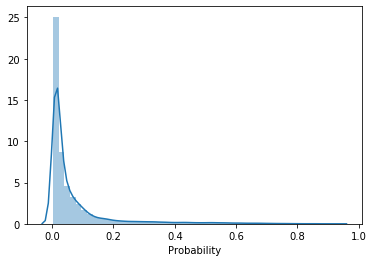

In [9]:
sns.distplot(result["Probability"])

In [10]:
result["Probability"].describe()

count    101503.000000
mean          0.069605
std           0.117667
min           0.002392
25%           0.011126
50%           0.023687
75%           0.069813
max           0.925571
Name: Probability, dtype: float64

In [11]:
result["Id"] = result["Id"].astype(int)
result["Probability"] = result["Probability"].astype(float)
result.to_csv("xgb_rd.csv", index=False)